# Adaptive Intelligence COM3240

#### Script that returns the learnign curve for each trial

In [15]:
import numpy as np

def Start(N, M):
    return np.array([np.random.randint(N), np.random.randint(M)])   #random start

def homing_nn(n_trials, learning_rate, eps, gamma, max_steps=50):

    # Solving homing task with on-policy TD (SARSA)


    ## Definition of the environment
    N = 3                               #height of the gridworld ---> number of rows
    M = 4                              #length of the gridworld ---> number of columns
    N_states = N * M                    #total number of states
    states_matrix = np.eye(N_states)
    N_actions = 4                                           #number of possible actions in each state: 1->N 2->E 3->S 4->W
    action_row_change = np.array([-1, 0, +1, 0])               #number of cell shifted in vertical as a function of the action
    action_col_change = np.array([0, +1, 0, -1])               #number of cell shifted in horizontal as a function of the action
    End = np.array([1, 1])                                  #terminal state--->reward
    s_end = np.ravel_multi_index(End, dims = (N, M), order = 'F')  #terminal state. Conversion in single index

    ## Parameters of the model
    #gamma = 0.9                        #discounting factor
    #learning_rate = 0.5                #constant step-size parameter (learning rate)
    #eps = 0.0                          #epsilon-greedy SARSA

    ## Rewards
    R = 10                              #only when the robot reaches the charger, sited in End state

    ## Variables
    weights = np.random.rand(N_actions, N_states)
    learning_curve = np.zeros((1, n_trials))

    ## SARSA

    # Start trials
    for trial in range(n_trials):

        # Initialization
        Start_mat = Start(N, M)
        s_start = np.ravel_multi_index(Start_mat, dims = (N, M), order = 'F')      #conversion in single index
        
        #Make sure the robot doesn't start on the goal
        while s_start == s_end:
            Start_mat = Start(N, M)
            s_start = np.ravel_multi_index(Start_mat, dims = (N, M), order = 'F')
        state = Start_mat                                                   #set current state
        s_index = s_start      
        step = 0

        # Start steps
        while s_index != s_end and step <= max_steps:

            step += 1
            learning_curve[0, trial]= step

            input_vector = states_matrix[:, s_index].reshape(N_states, 1)         #convert the state into an input vector

            #compute Qvalues. Qvalue = logsig(weights*input). Qvalue is 2x1, one value for each output neuron
            Q = 1 / ( 1 + np.exp( - weights.dot(input_vector)))    #Qvalue is 2x1 implementation of logsig

            #eps-greedy policy implementation
            greedy = (np.random.rand() > eps)               #1--->greedy action 0--->non-greedy action
            if greedy:
                action = np.argmax(Q)                           #pick best action
            else:
                action = np.random.randint(N_actions)           #pick random action


            state_new = np.array([0, 0])
            #move into a new state
            state_new[0]= state[0] + action_row_change[action]
            state_new[1]= state[1] + action_col_change[action]

            #initialise reward
            r = 0
            
            #put the robot back in grid if it goes out.
            lt_x = state_new[0] < 0
            if lt_x:
                state_new[0]= 0
            gt_x = state_new[0] >= N
            if gt_x:
                state_new[0]= N-1
            lt_y = state_new[1] < 0
            if lt_y:
                state_new[1]= 0
            gt_y = state_new[1] >= M
            if gt_y:
                state_new[1]= M-1
            #give a negative reward
            if lt_x or gt_x or lt_y or gt_y:
                r = -1
            
            s_index_new = np.ravel_multi_index(state_new, dims = (N, M), order = 'F')  #conversion in a single index

            #if is not the first step
            if step > 1: 
                #update Qvalues
                weights += learning_rate * (r_old + gamma * Q[action] - Q_old) * output_old.dot(input_old.T)

            #store variables for sarsa computation in the next step
            output = np.zeros((N_actions, 1))
            output[action]= 1

            #update variables
            input_old = input_vector
            output_old = output
            Q_old = Q[action]
            r_old = r

            state[0]= state_new[0]
            state[1]= state_new[1]
            s_index = s_index_new

            ## check if state is terminal and update the weights consequently
            if s_index == s_end:
                weights += learning_rate * (R - Q_old) * output_old.dot(input_old.T)
                pass


    return learning_curve


#### Call the function homing_nn


(1, 100)


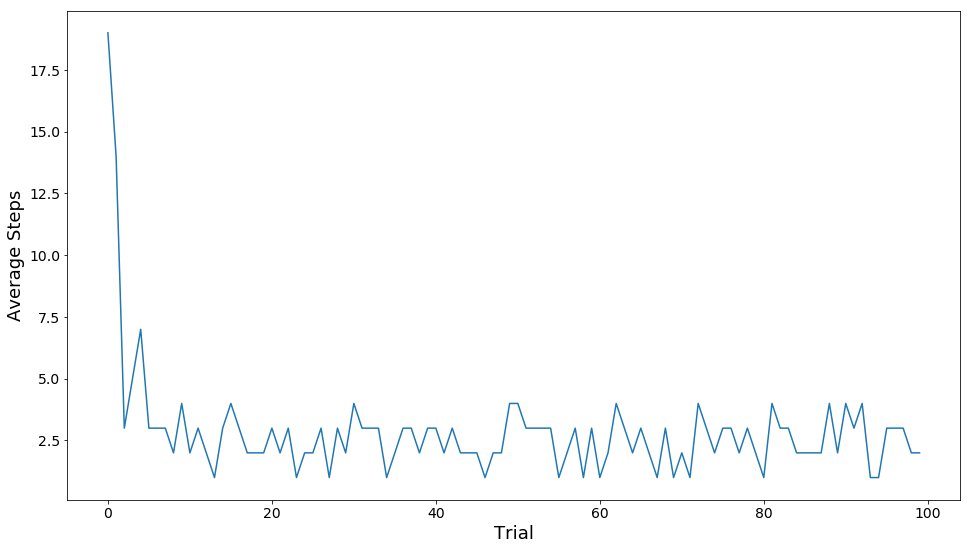

In [16]:
#We will call this procedure one run of the algorithm.
n_trials = 100
gamma=0.9                        #discounting factor
learning_rate=0.5                #constant step-size parameter (learning rate)
eps=0.0                          #epsilon-greedy SARSA
l_curve=homing_nn(n_trials,learning_rate,eps,gamma)
print(l_curve.shape)

import matplotlib.pyplot as plt
plt.figure(figsize=(16, 9))
plt.plot(l_curve.T)
plt.xlabel('Trial',fontsize=fontsize)
plt.ylabel('Average Steps',fontsize=fontsize)
plt.tick_params(axis='both', which='major', labelsize=14)
plt.show()
plt.show()

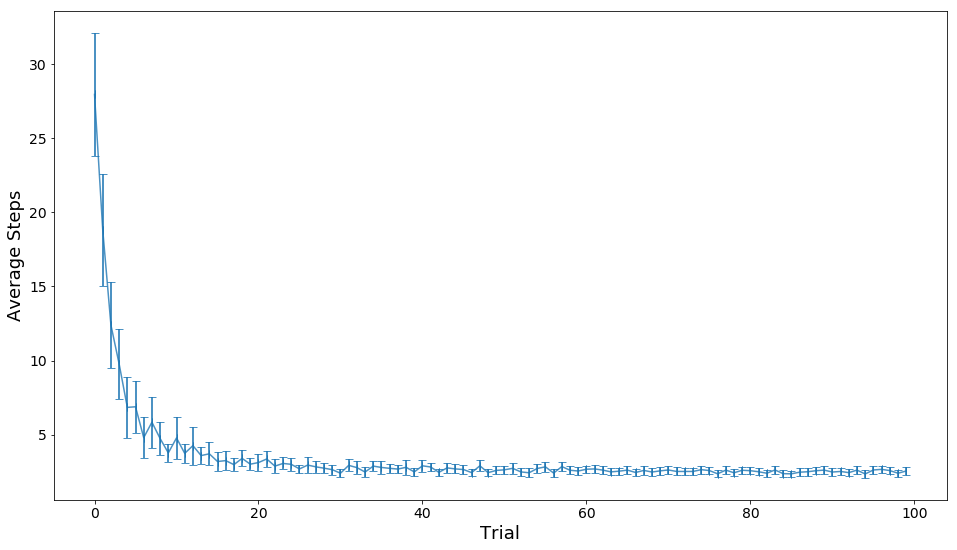

In [17]:
#produce a curve that is the average of the learning curves of the individual runs.
runs=100
total_steps=np.zeros((runs,n_trials))
fontsize=18
for j in range(runs):
    total_steps[j,:]=homing_nn(n_trials,learning_rate,eps,gamma)
plt.figure(figsize=(16, 9))
means=np.mean(total_steps, axis=0)
errors=2*np.std(total_steps, axis=0)/np.sqrt(runs)
plt.errorbar(np.arange(n_trials), means, errors, 0, elinewidth=2, capsize=4, alpha=0.8)
plt.xlabel('Trial',fontsize=fontsize)
plt.ylabel('Average Steps',fontsize=fontsize)
plt.tick_params(axis='both', which='major', labelsize=14)
plt.show()